#  Prep

## Dataset

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# %cd /content/drive/MyDrive/NYU/CS7641 ML/assignment1

/content/drive/MyDrive/NYU/CS7641 ML/assignment1


In [3]:
# https://www.kaggle.com/competitions/titanic/data?select=train.csv

## Import libs

In [4]:
import numpy as np
import pandas as pd
# import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
%matplotlib inline



######################## 
# preprocessing

# handle na
from sklearn.impute import SimpleImputer, KNNImputer

# scaler
from sklearn.preprocessing import StandardScaler, RobustScaler

# discretize
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import KBinsDiscretizer

# categorical
from sklearn.preprocessing import OneHotEncoder

# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# transform
from sklearn.preprocessing import PowerTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# PCA
from sklearn.decomposition import PCA

# feature selection
from sklearn.feature_selection import SelectKBest 
from scipy.stats import pearsonr

######################## 
# model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
import statsmodels.formula.api as smf

######################## 
# metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate



import warnings
warnings.filterwarnings('ignore')

# Get data and exploratory data analysis

In [5]:
data = pd.read_csv('titanic.csv')

data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


volatile, citric acid, chlorides, density, pH have outlier values that are due to record mistake.


## Identify numeric vs categorical variables

In [6]:
columns = data.columns[:-1]
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numeric_features = data.select_dtypes(exclude=['object']).columns.tolist()
numeric_features.remove('Survived')

print('Categorical features:', categorical_features)
print('Numeric features:', numeric_features)

Categorical features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numeric features: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


## Train test split

In [7]:
train_all_ratio = 0.9
train_ratio = 0.8

X, y = data.loc[:], data['Survived']
del X['Survived']
num_observations = X.shape[0]

X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, shuffle=True, train_size=train_all_ratio, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, shuffle=True, train_size=train_ratio, random_state=42)

data_train_all = X_train_all.copy()
data_train_all['Survived'] = y_train_all


print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'X_train_all shape: {X_train_all.shape}')
print(f'y_train_all shape: {y_train_all.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X shape: (891, 11)
y shape: (891,)
X_train_all shape: (801, 11)
y_train_all shape: (801,)
X_test shape: (90, 11)
y_test shape: (90,)


## Basic EDA

## Check the distribution

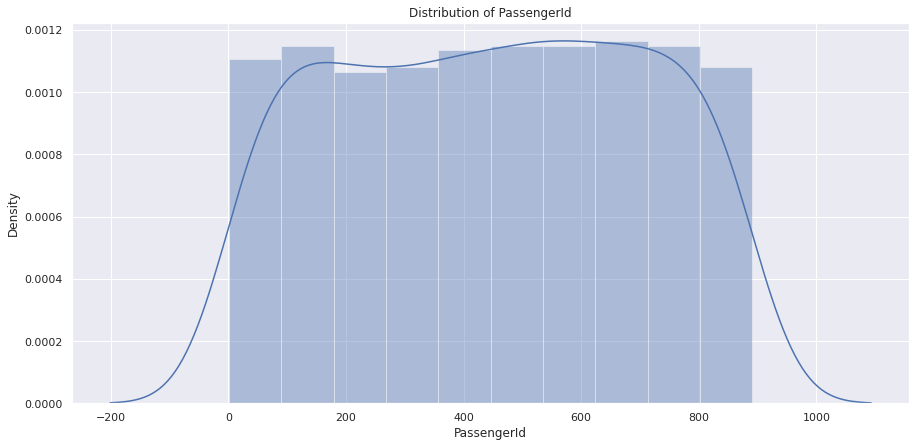

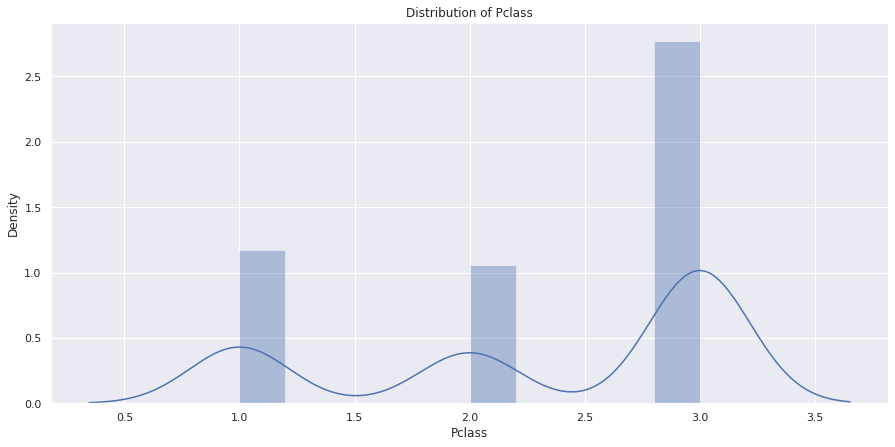

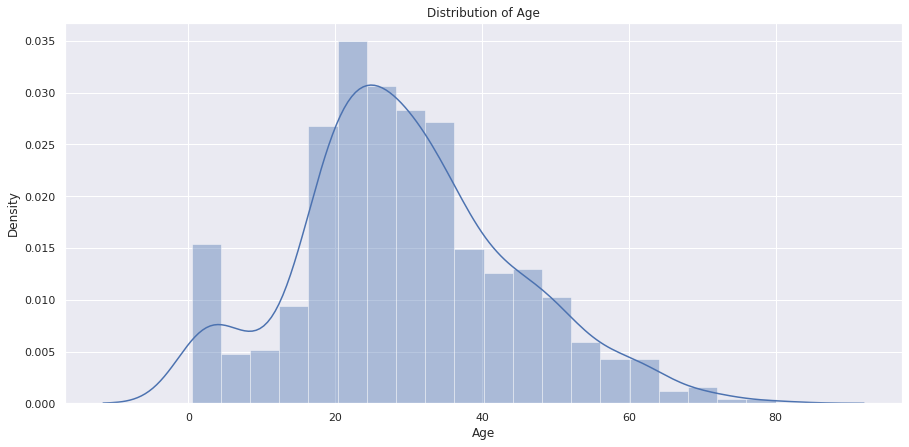

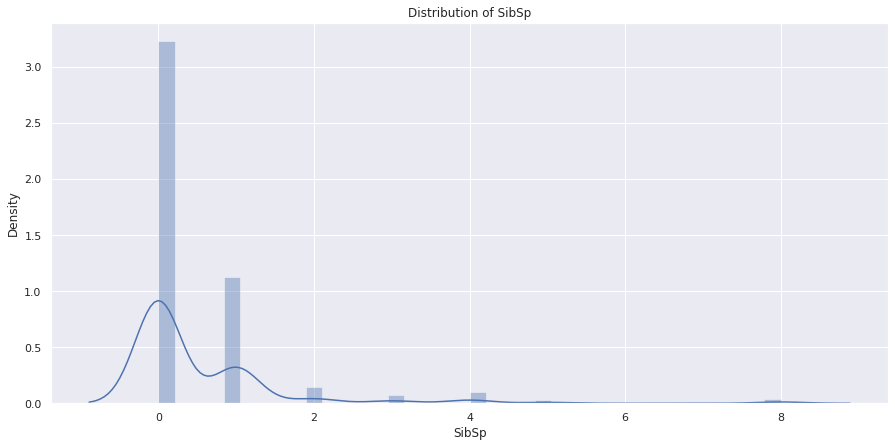

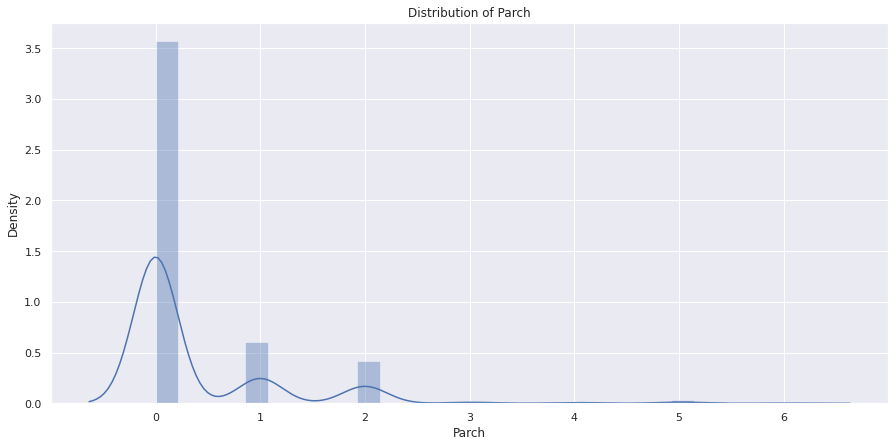

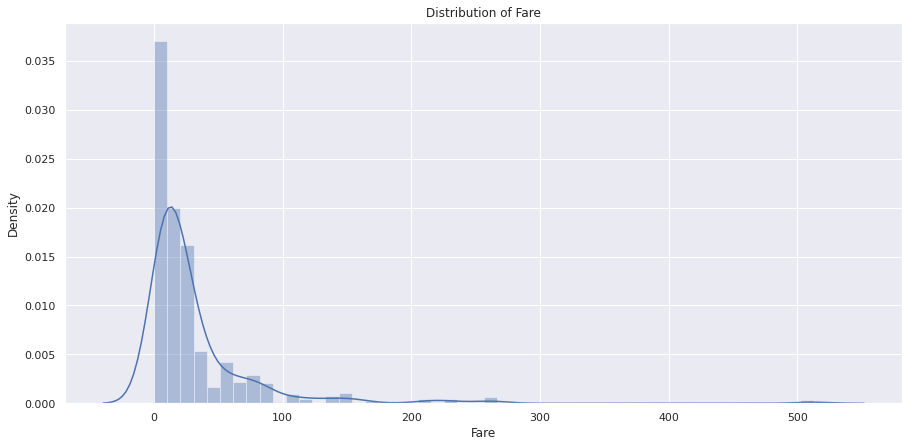

In [8]:
for col in numeric_features:
    plt.figure(figsize=(15,7))
    sns.distplot(X_train_all[col])
    plt.title(f'Distribution of {col}')
    

## Check the sparsity

,Missing value percent
PassengerId,0.00%
Pclass,0.00%
Name,0.00%
Sex,0.00%
Age,18.18%
SibSp,0.00%
Parch,0.00%
Ticket,0.00%
Fare,0.00%
Cabin,69.47%


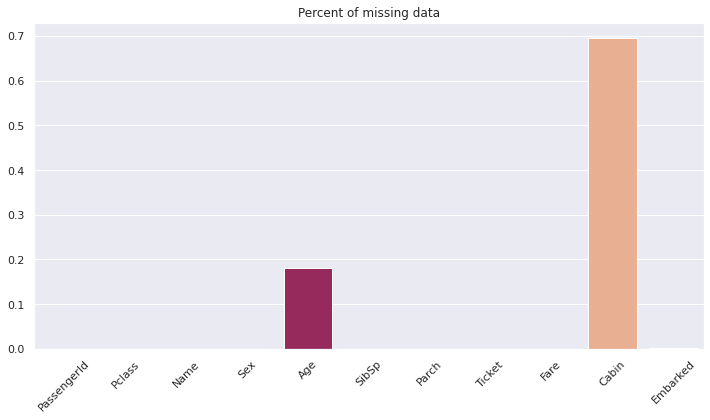

In [9]:
nan_percent = pd.isnull(X_train_all).sum(axis=0)/data.shape[0]

plt.figure(figsize=(12,6))
sns.barplot(x=nan_percent.index, y=nan_percent, palette='rocket')
plt.xticks(rotation=45)
plt.title('Percent of missing data')

nan_percent.to_frame().rename(columns={0: 'Missing value percent'}).style.format("{:.2%}")

## Linear relationship

Text(0.5, 1.0, 'Top negative correlated featurs')

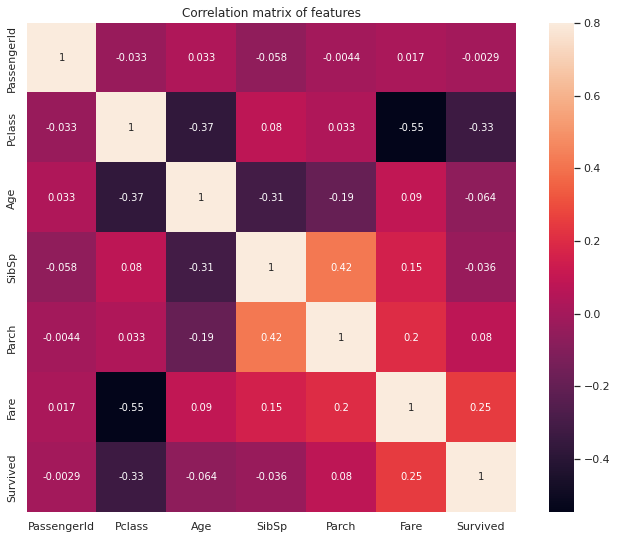

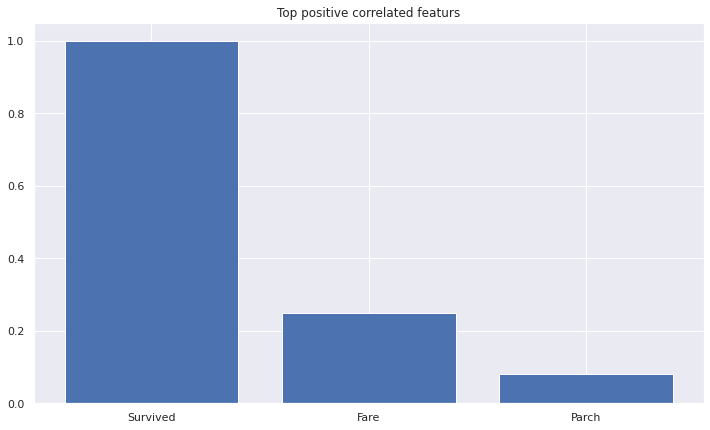

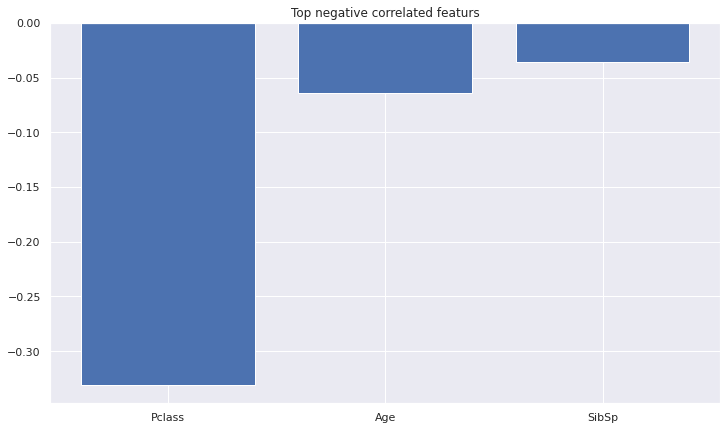

In [10]:
corrmat = data_train_all.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);
plt.title('Correlation matrix of features')

plt.subplots(figsize=(12, 7))
top_corr_features = corrmat['Survived'].sort_values(ascending=False).iloc[:3]
plt.bar(top_corr_features.index, top_corr_features.values)
plt.title('Top positive correlated featurs')

plt.subplots(figsize=(12, 7))
top_corr_features = corrmat['Survived'].sort_values(ascending=True).iloc[:3]
plt.bar(top_corr_features.index, top_corr_features.values)
plt.title('Top negative correlated featurs')

# Prepare the data

### Remove rows that has large percentage of NaNs

In [11]:
# check sparsity of row data and remove sparse rows
def check_sparsity_rows(df, remove_threshold=1):
    remove_row = list(df[df.isnull().mean(axis=1) > remove_threshold].index)
    keep_row = list(df[df.isnull().mean(axis=1) <= remove_threshold].index)

    print(f'Percent of Removed Rows: {len(remove_row)/df.shape[0]:.2%}')
    return keep_row

keep_row = check_sparsity_rows(X_train_all, remove_threshold=0.8)
X_train_all = X_train_all.loc[keep_row, :]
y_train_all = y_train_all.loc[keep_row]
print("X_train_all shape: ", X_train_all.shape)
print("y_train_all shape: ", y_train_all.shape)

Percent of Removed Rows: 0.00%
X_train_all shape:  (801, 11)
y_train_all shape:  (801,)


## Handle outliers

### Check the outliers

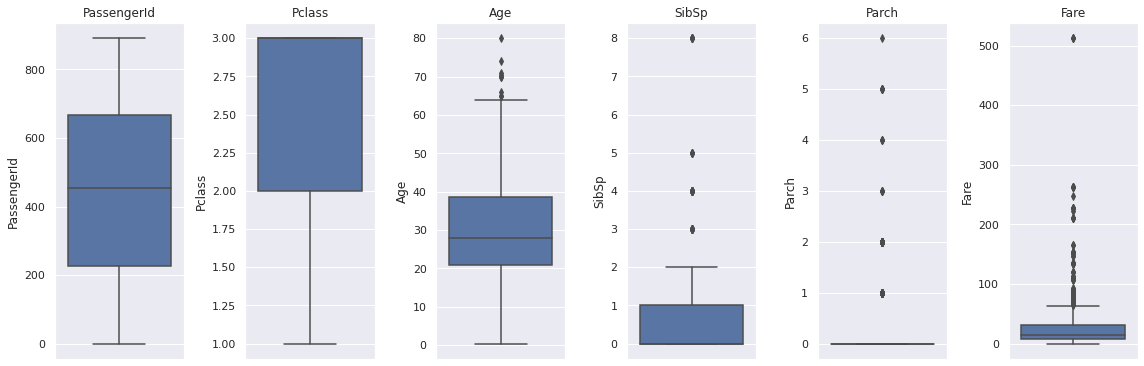

In [12]:
plt.figure(figsize=(16,10))

for i, col in enumerate(numeric_features):    
    plt.subplot(2,6,i + 1)
    sns.boxplot(y=col, data=X_train_all)
    plt.title(col)

plt.tight_layout()


### Univariate outlier, winsorize

In [13]:
class Winsorize(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.med_ = None
        self.mad_ = None

    def fit(self, X, y=None):
        self.med_ = np.mean(X, axis=0)        
        self.mad_ = np.median(np.abs(X - self.med_), axis=0)

        return self

    def transform(self, X, y=None):
        col_len = X.shape[1]
        for i in range(col_len):
            val = X[:,i]
            X[:,i][val>self.med_[i]+2*self.mad_[i]] = self.med_[i] + 2*self.mad_[i]
            X[:,i][val<self.med_[i]-2*self.mad_[i]] = self.med_[i] - 2*self.mad_[i]        

        return X

## Transformation and feature engineering

## PCA on correlated features

## Feature selection

## Build pipeline

In [14]:

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('winsorize', Winsorize()),
    ('scale', RobustScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),         
    ]
)

X_train_all_trans = preprocessor.fit_transform(X_train_all)

In [15]:
X_train_all_trans.shape

(801, 1567)

# Model building

In [16]:
def run_model(model_pipleline, X_train_all, y_train_all, title):    
    train_num = X_train.shape[0]
    result = []

    for train_percent in np.linspace(0.1, 1, 20):
        X_train_select = X_train.iloc[:int(train_percent*train_num), :]
        y_train_select = y_train.iloc[:int(train_percent*train_num)]
        model_pipeline.fit(X_train_select, y_train_select)
        score_train = f1_score(y_train_select, model_pipeline.predict(X_train_select), average='macro')
        score_valid = f1_score(y_valid, model_pipeline.predict(X_valid), average='macro')
        result.append([train_percent, score_train, score_valid])
    # plot learning curve
    learning_curve = pd.DataFrame(result, columns=['percent', 'Train_F1_score', 'Valid_F1_score']).set_index('percent')
    learning_curve.plot(figsize=(12,6))
    plt.xlabel('Train Data Usage Rate')
    plt.ylabel('F1 Score')
    plt.title(f'Red Wine - Learning Curve for {title}')

    model_pipeline.fit(X_train_all, y_train_all)
    score_test = f1_score(y_test, model_pipeline.predict(X_test), average='macro')
    print(f'{title}, test score: {score_test}')

    return learning_curve, model_pipeline, score_valid


def plot_valid_curve(valid_result, param_name):
    valid_curve = pd.DataFrame(valid_result, columns=[param_name, 'F1_score']).set_index(param_name)
    print(valid_curve)
    valid_curve.plot(figsize=(12,6))
    plt.xlabel(param_name)
    plt.ylabel('Validation F1 Score')
    plt.title(f'Red Wine - Validation Curve')

## Decision Trees


DecisionTreeClassifier: depth=2.0, test score: 0.7456189937817976

DecisionTreeClassifier: depth=3.0, test score: 0.8271668160286776

DecisionTreeClassifier: depth=5.0, test score: 0.8502112405581872

DecisionTreeClassifier: depth=10.0, test score: 0.7896103896103897

DecisionTreeClassifier: depth=20.0, test score: 0.7896103896103897

DecisionTreeClassifier: depth=30.0, test score: 0.7896103896103897
       F1_score
depth          
2      0.700620
3      0.831237
5      0.851774
10     0.850624
20     0.837045
30     0.803110


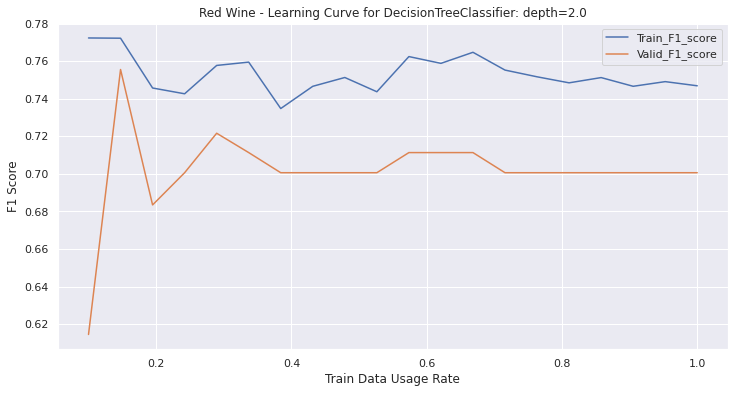

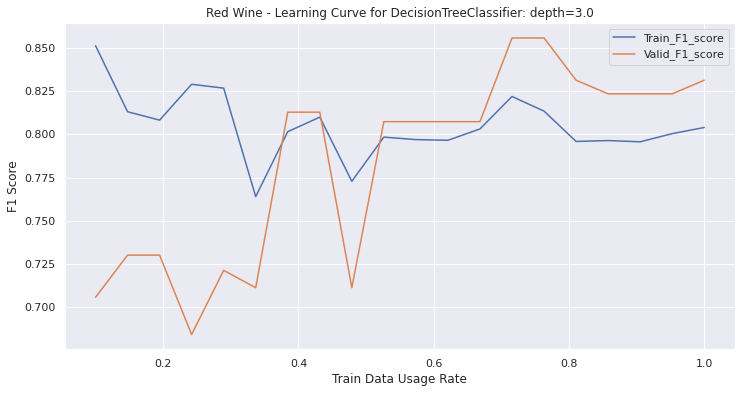

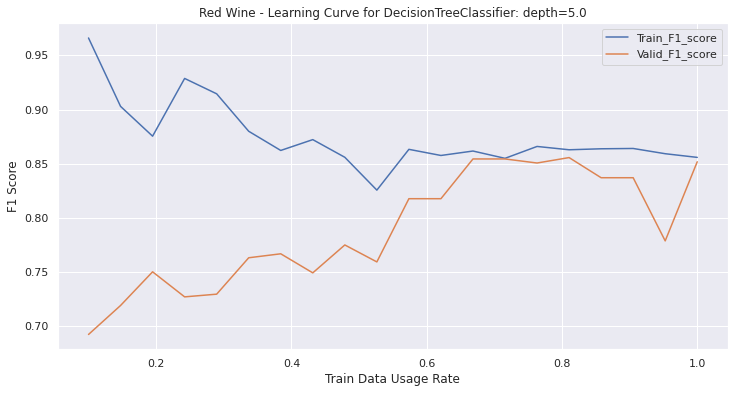

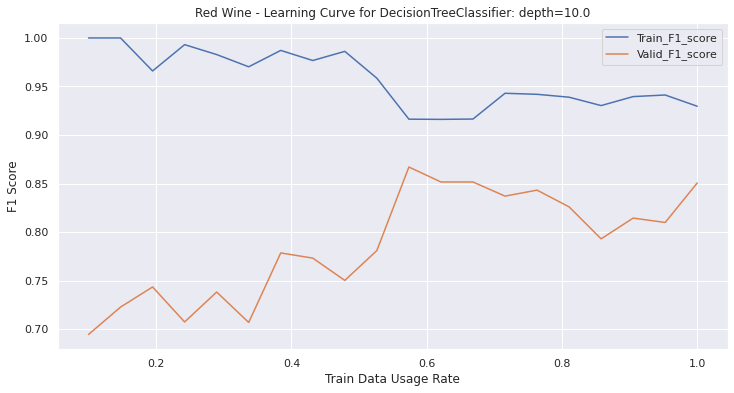

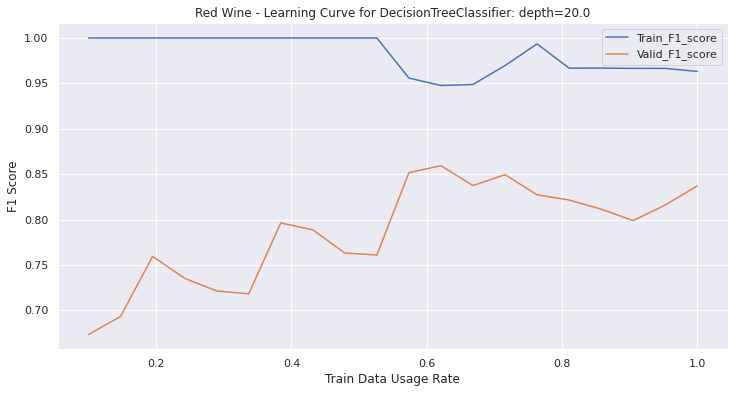

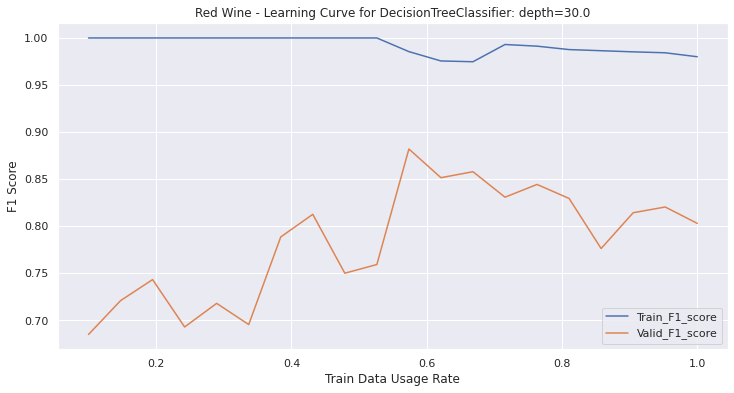

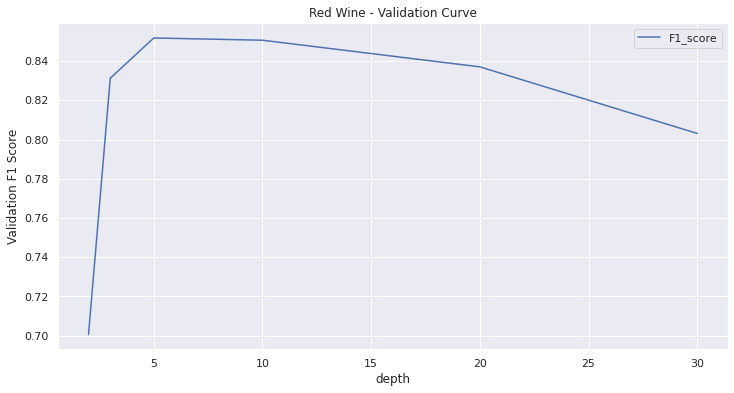

In [17]:
valid_result = []

for depth in [2, 3, 5, 10, 20, 30]:
    print()
    title = f'DecisionTreeClassifier: depth={depth:.1f}'
    model_pipeline = Pipeline([
         ('preprocessor', preprocessor),
         ('reg', DecisionTreeClassifier(max_depth=depth))
    ])
    learning_curve, model_pipeline, score_valid = run_model(model_pipeline, X_train_all, y_train_all, title)
    valid_result.append([depth, score_valid])
  
plot_valid_curve(valid_result, 'depth')  

## KNN


KNN: k=2.0, test score: 0.7817887931034482

KNN: k=3.0, test score: 0.7934727180010198

KNN: k=5.0, test score: 0.7828571428571427

KNN: k=10.0, test score: 0.800235017626322
             F1_score
n_neighbors          
2            0.680435
3            0.713416
5            0.789046
10           0.800825


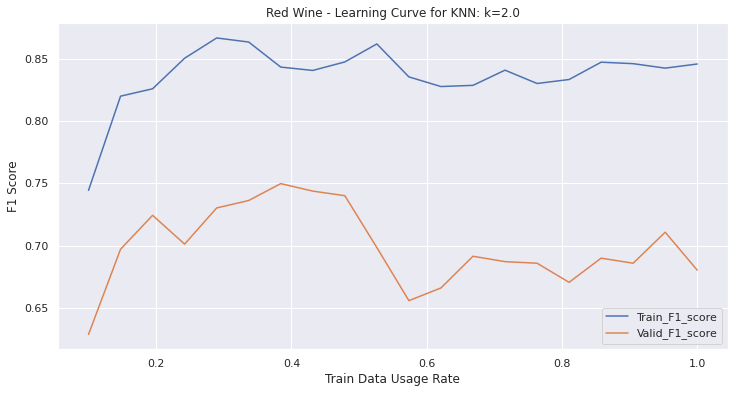

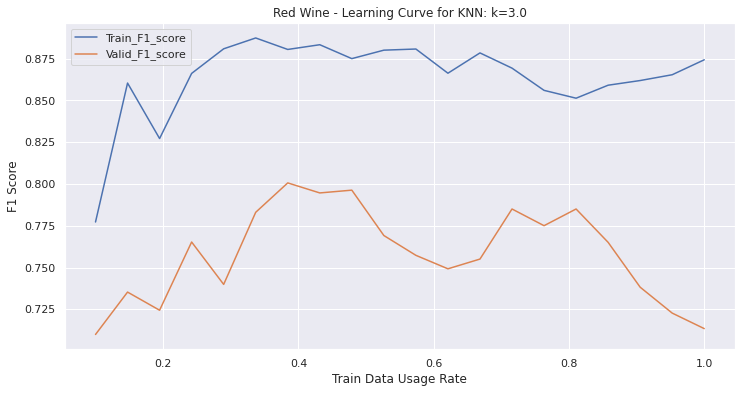

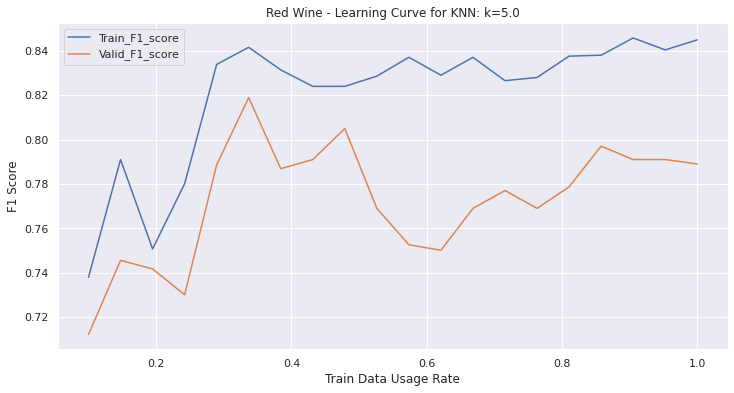

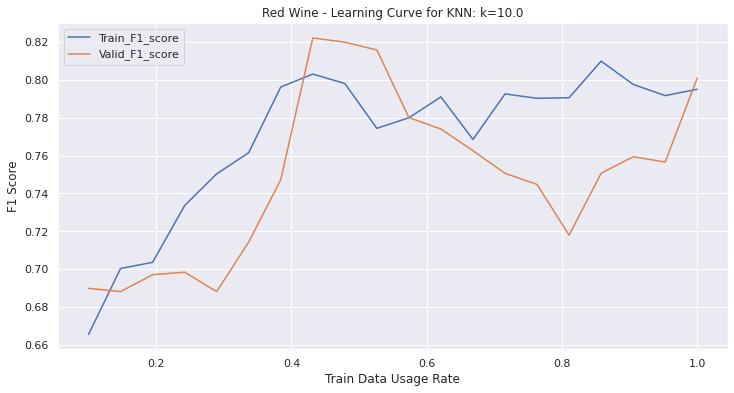

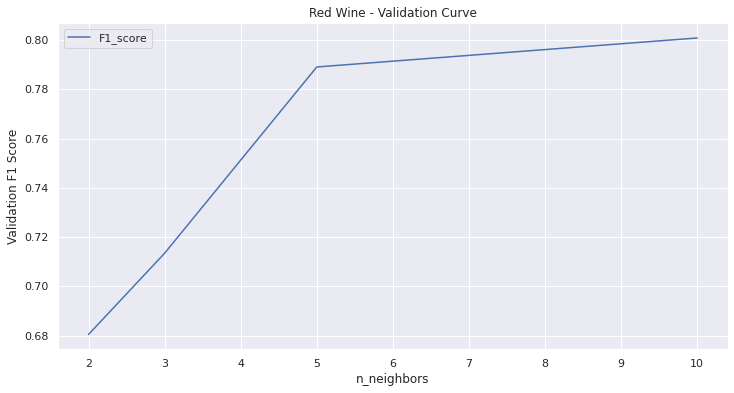

In [18]:
valid_result = []

for n_neighbors in [2, 3, 5, 10]:
    print()
    title = f'KNN: k={n_neighbors:.1f}'
    model_pipeline = Pipeline([
         ('preprocessor', preprocessor),
         ('reg', KNeighborsClassifier(n_neighbors=n_neighbors))
    ])
    learning_curve, model_pipeline, score_valid = run_model(model_pipeline, X_train_all, y_train_all, title)
    valid_result.append([n_neighbors, score_valid])
  
plot_valid_curve(valid_result, 'n_neighbors')  

## Neural networks


MLPClassifier: hidden_layer_size=5.0, test score: 0.8082466474495551

MLPClassifier: hidden_layer_size=20.0, test score: 0.8502112405581872

MLPClassifier: hidden_layer_size=100.0, test score: 0.8255588577335573

MLPClassifier: hidden_layer_size=500.0, test score: 0.8623151453340132
             F1_score
hidden_size          
5            0.816390
20           0.810396
100          0.793590
500          0.810396


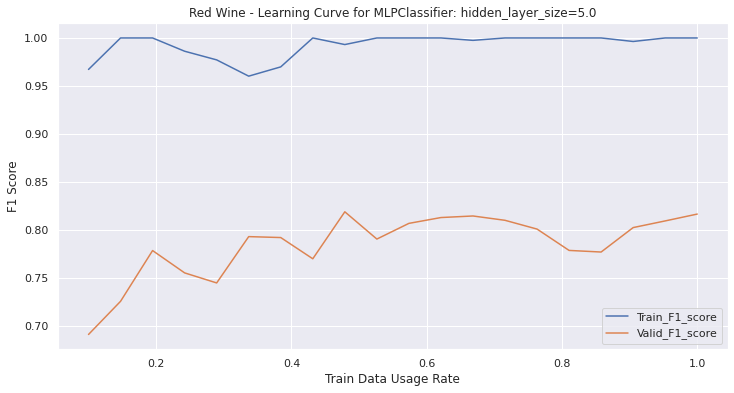

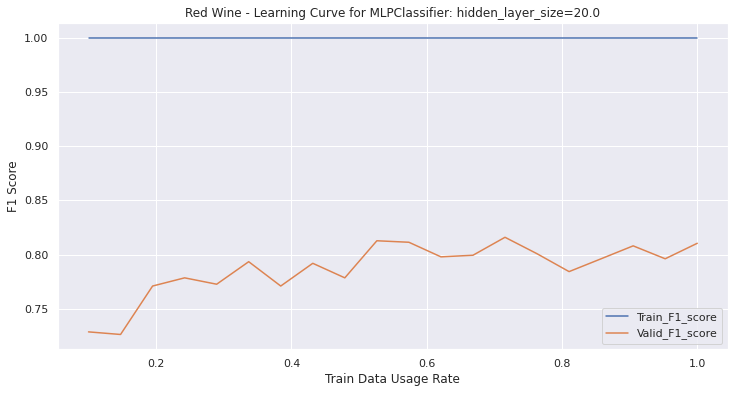

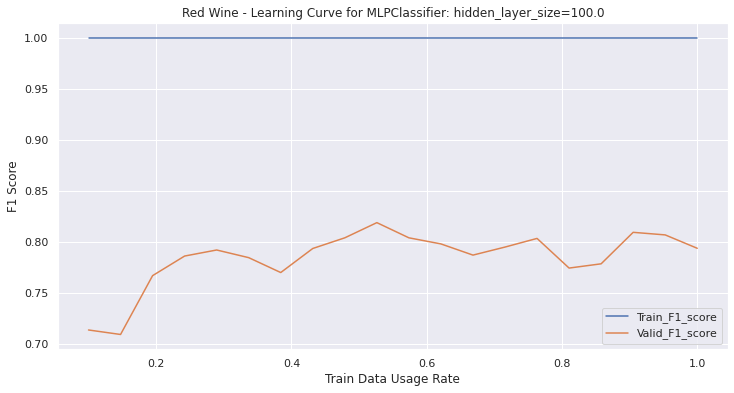

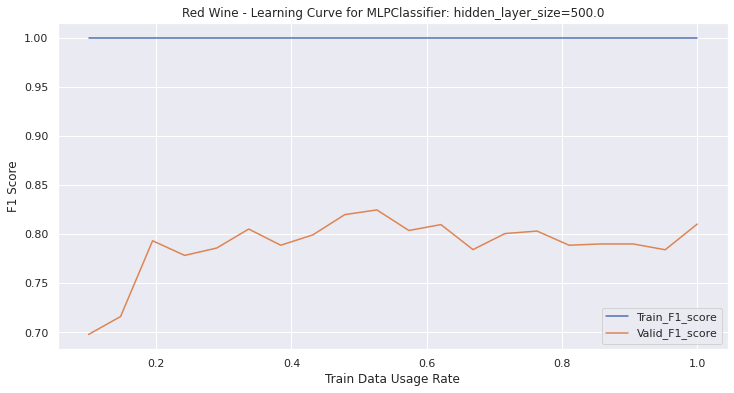

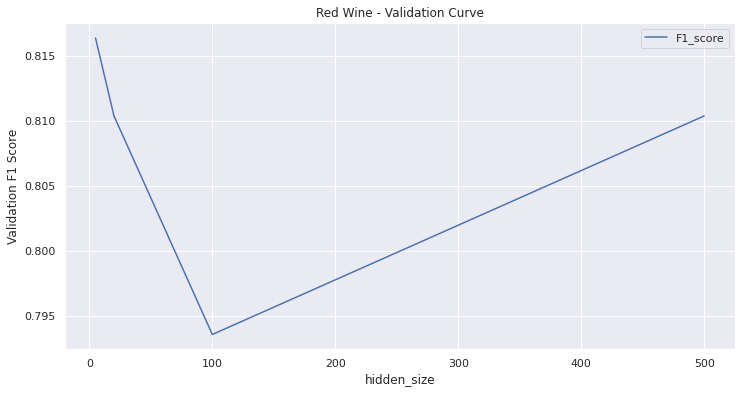

In [19]:
valid_result = []

for hidden_size in [5, 20, 100, 500]:
    print()
    title = f'MLPClassifier: hidden_layer_size={hidden_size:.1f}'
    model_pipeline = Pipeline([
         ('preprocessor', preprocessor),
         ('reg', MLPClassifier(hidden_layer_sizes=(hidden_size,)))
    ])

    learning_curve, model_pipeline, score_valid = run_model(model_pipeline, X_train_all, y_train_all, title)
    valid_result.append([hidden_size, score_valid])
  
plot_valid_curve(valid_result, 'hidden_size')  

## Boosting


GradientBoostingClassifier: max_depth=5.0, test score: 0.8488176767024164

GradientBoostingClassifier: max_depth=10.0, test score: 0.8148148148148149

GradientBoostingClassifier: max_depth=20.0, test score: 0.8393676695563488

GradientBoostingClassifier: max_depth=50.0, test score: 0.8514285714285714
           F1_score
max_depth          
5          0.854374
10         0.861921
20         0.825038
50         0.828146


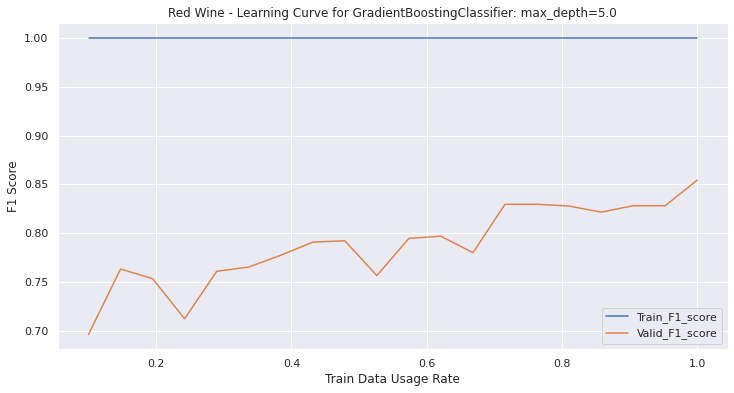

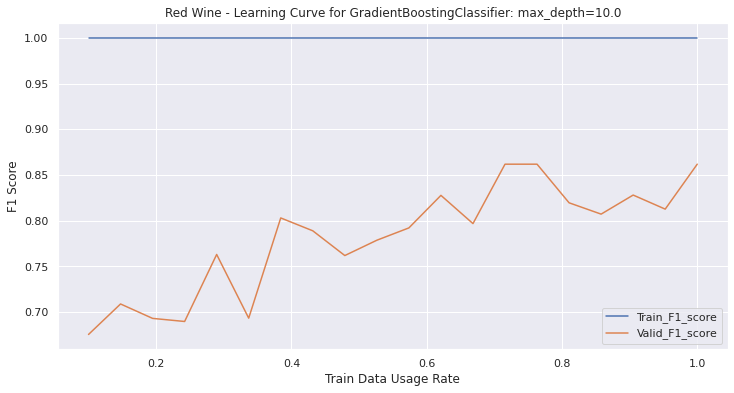

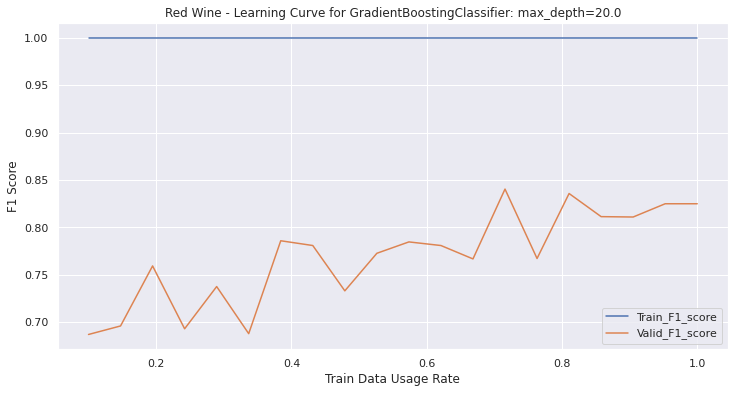

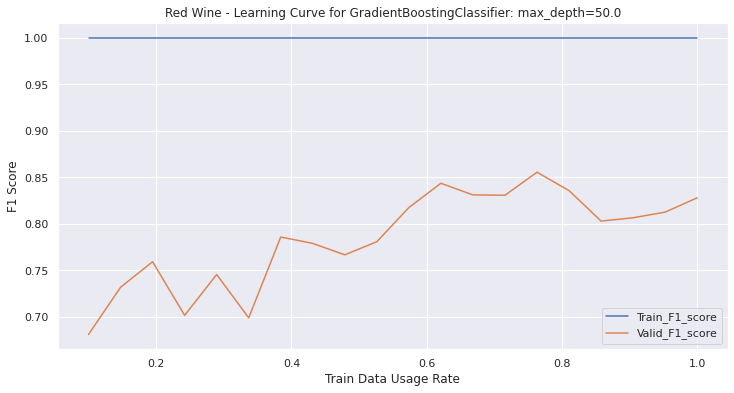

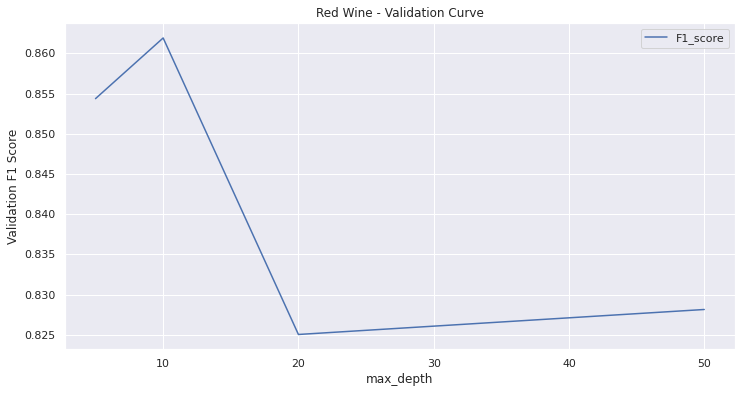

In [20]:
valid_result = []


for max_depth in [5, 10, 20, 50]:
    print()
    title = f'GradientBoostingClassifier: max_depth={max_depth:.1f}'
    model_pipeline = Pipeline([
         ('preprocessor', preprocessor),
         ('reg', GradientBoostingClassifier(max_depth=max_depth))
    ])
    learning_curve, model_pipeline, score_valid = run_model(model_pipeline, X_train_all, y_train_all, title)
    valid_result.append([max_depth, score_valid])
  
plot_valid_curve(valid_result, 'max_depth')  

## SVM


SVC: Regularization paramete=1.000, test score: 0.8271668160286776

SVC: Regularization paramete=0.100, test score: 0.8057142857142857

SVC: Regularization paramete=0.010, test score: 0.37499999999999994

SVC: Regularization paramete=0.001, test score: 0.37499999999999994
       F1_score
C              
1.000  0.799109
0.100  0.746855
0.010  0.390152
0.001  0.390152


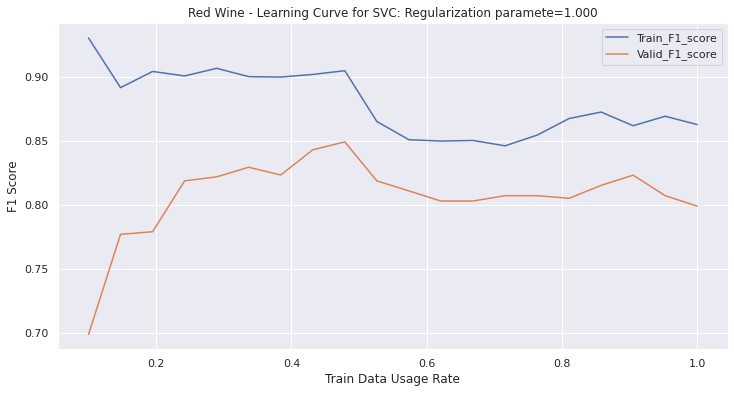

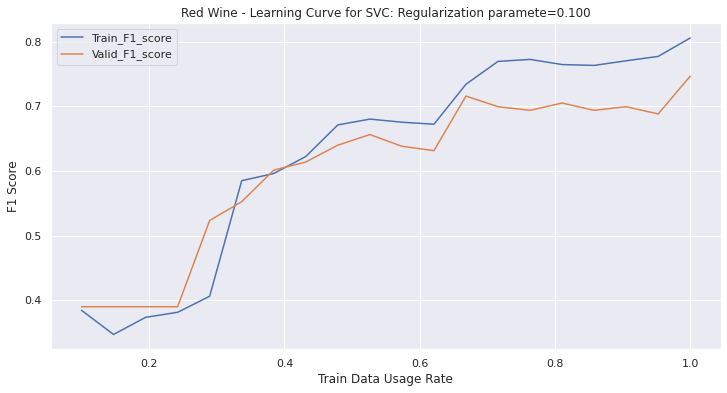

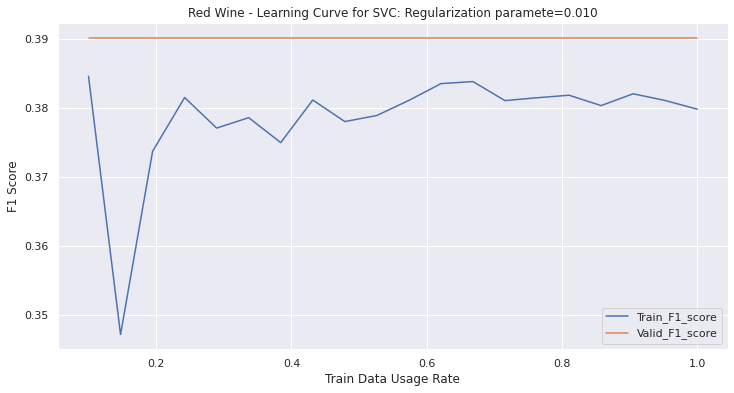

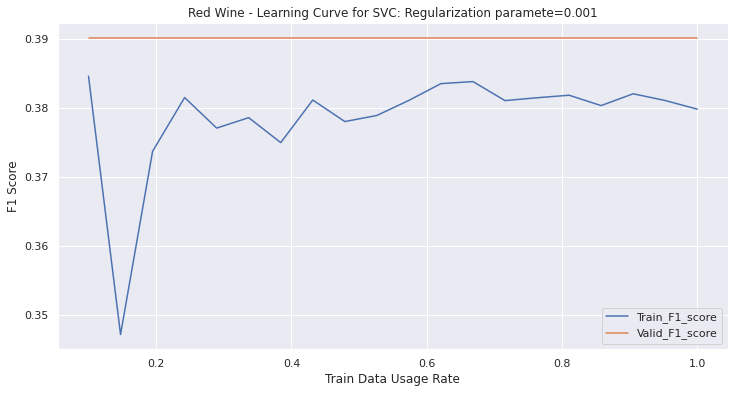

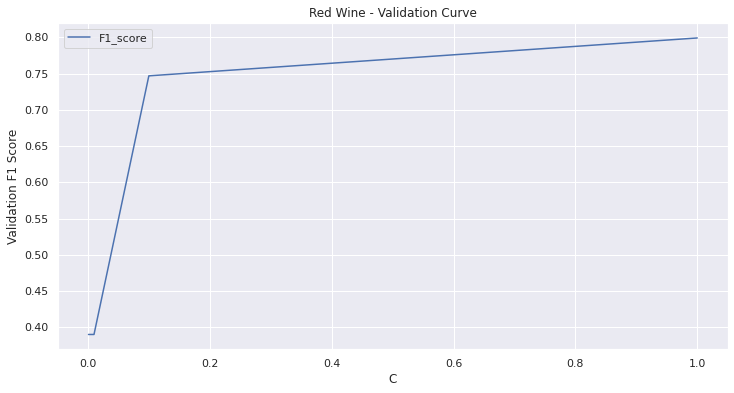

In [21]:
valid_result = []

for C in [1, 0.1, 0.01, 0.001]:
    print()
    title = f'SVC: Regularization paramete={C:.3f}'
    model_pipeline = Pipeline([
         ('preprocessor', preprocessor),
         ('reg', SVC(C=C))
    ])
    learning_curve, model_pipeline, score_valid = run_model(model_pipeline, X_train_all, y_train_all, title)
    valid_result.append([C, score_valid])
  
plot_valid_curve(valid_result, 'C')  

# Test set performance